## Dataset loading



In [ ]:
#! pip install gensim

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import string
import re
import random
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import word2vec, FastText
import gensim.downloader
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ner.csv.zip
!unzip /content/drive/MyDrive/ner_dataset.csv.zip

Archive:  /content/drive/MyDrive/ner.csv.zip
  inflating: ner.csv                 
Archive:  /content/drive/MyDrive/ner_dataset.csv.zip
  inflating: ner_dataset.csv         


In [ ]:
df=pd.read_csv('/content/ner_dataset.csv', encoding= 'unicode_escape')

In [ ]:
df['Sentence #']=df['Sentence #'].ffill()

In [ ]:
%pip install datasets transformers
%pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.4 MB/s eta 0:00:00


In [ ]:
# import pandas as pd
# column_names = ['Token', 'POS']
# df_train = pd.read_csv("wnut 16.txt.conll", sep='\t', header=None,names=column_names ,comment='#')
# df_test = pd.read_csv("wnut 16test.txt.conll", sep='\t', header=None,names=column_names ,comment='#')
# df_train.head()

In [ ]:
df=df[['Sentence #','Word','Tag']]
df.rename(columns={'Sentence #':'Sentence','Word':'Token','Tag':'POS'},inplace=True)

<ipython-input-10-e444fee1884a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Sentence #':'Sentence','Word':'Token','Tag':'POS'},inplace=True)


In [ ]:
df

,Sentence,Token,POS
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
...,...,...,...
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O
1048573,Sentence: 47959,the,O


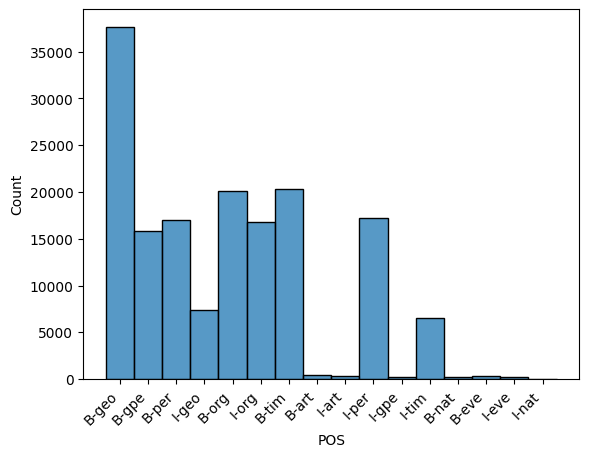

In [ ]:
sns.histplot(df[df['POS']!='O']['POS'])
plt.xticks(rotation=45, ha='right')
plt.show()

Clearly there is imbalance in the dataset. Person, Other and loc has the highest count compare to other tags. We will take care of that in loss

In [ ]:
df.info() #There seems to be no null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Sentence  1048575 non-null  object
 1   Token     1048575 non-null  object
 2   POS       1048575 non-null  object
dtypes: object(3)
memory usage: 24.0+ MB


In [ ]:
print('Number of sentences are '+str(df['Sentence'].nunique()))
print('Number of Vocabs are '+str(df['Token'].nunique()))

Number of sentences are 47959
Number of Vocabs are 35178


## BERT

### Preprocessing

In [ ]:
# ! pip install transformers
# ! pip install plotly


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


import transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


In [ ]:
# sentence = df.groupby("Sentence")["Token"].apply(list).values
# #pos = dataframe.groupby(by = 'Sentence #')['POS'].apply(list).values
# tag = df.groupby(by = 'Sentence')['POS'].apply(list).values

In [ ]:
# Over Sampling
lst = [df]
max_size = 1356
for class_index, group in df.groupby('POS'):
        if len(group)< max_size:
            lst.append(group.sample(max_size-len(group), replace=True))
train_sample = pd.concat(lst)

In [ ]:
train_sample=train_sample.sort_values(by='Sentence')

In [ ]:
# Token and POS Encoding
def process_data(df):
    enc_pos = preprocessing.LabelEncoder()
    #enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])

    sentences = df.groupby("Sentence")["Token"].apply(list).values
    pos = df.groupby("Sentence")["POS"].apply(list).values
    return sentences, pos, enc_pos

sentence,pos,enc_pos = process_data(train_sample.copy())

<ipython-input-20-8238a877c147>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])


In [ ]:
#pos

In [ ]:
# Using BERT Auto-Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
MAX_LEN = 256
def tokenize(data,max_len = MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')


        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids),np.vstack(attention_mask)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Train test split
X_train,X_test,y_train,y_test = train_test_split(sentence,pos,random_state=42,test_size=0.1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((43163,), (4796,), (43163,), (4796,))

In [ ]:
X_train

array([list(['.', 'corporate', 'on', 'down', 'crime', 'are', 'they', 'that', 'insisted', 'officials', 'cracking', 'Kremlin']),
       list(['Coast', 'were', 'also', 'likely', 'agenda', 'top', 'the', '.', 'Ivory', 'to', 'in', 'Sudan', 'peace', 'faltering', 'the', 'and', 'region', 'Darfur', 'western', "'s", 'in', 'conflict', 'process', 'The']),
       list(['said', 'The', 'Chinese', 'foreign', 'ministry', "'s", 'on', 'Web', 'an', 'with', 'meeting', 'a', 'at', 'concerns', 'Burma', "'s", 'Beijing', 'conveyed', 'Wei', 'Wei', 'chief', 'department', 'affairs', 'consular', 'that', 'Saturday', 'site', 'its', 'official', 'from', 'embassy', '.']),
       ...,
       list(['1990s', 'facing', 'more', 'than', '60', 'counts', 'war', 'crimes', 'and', 'crimes', 'against', 'humanity', 'Hague', 'for', 'his', 'role', 'in', 'the', 'Balkan', 'wars', 'in', 'the', '.', 'of', 'in', 'tribunal', 'Milosevic', 'had', 'been', 'on', 'at', 'trial', 'the', 'United', 'Nations', 'war', 'crime', 'the']),
       list(['Li

In [ ]:
# Calling tokenization function
input_ids,attention_mask = tokenize(X_train,max_len = MAX_LEN)
val_input_ids,val_attention_mask = tokenize(X_test,max_len = MAX_LEN)

100%|██████████| 4796/4796 [00:03<00:00, 1570.28it/s]


In [ ]:
#val_input_ids

In [ ]:
# TEST: Checking Padding and Truncation length's
was = list()
for i in range(len(input_ids)):
    was.append(len(input_ids[i]))
set(was)

{256}

In [ ]:
# Train Padding
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [0] * (MAX_LEN-len(y_test[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

{256}

In [ ]:
# Train Padding
train_tag = list()
for i in range(len(y_train)):
    train_tag.append(np.array(y_train[i] + [0] * (MAX_LEN-len(y_train[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)

{256}

In [ ]:
#train_tag[0].shape

### Bert Modeling

In [ ]:
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def create_model(bert_model,max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks,return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(22,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
import tensorflow  as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.91.188.210:8470


Number of replicas: 8


In [ ]:
with strategy.scope():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    model = create_model(bert_model,MAX_LEN)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
early_stopping = EarlyStopping(mode='min',patience=3)
history_bert = model.fit([input_ids,attention_mask],np.array(train_tag),validation_data = ([val_input_ids,val_attention_mask],np.array(test_tag)),epochs = 5,batch_size = 32,callbacks = early_stopping,verbose = True)

Epoch 1/5


1349/1349 [==============================] - 251s 117ms/step - loss: 0.0929 - accuracy: 0.9776 - val_loss: 0.0414 - val_accuracy: 0.9878
Epoch 2/5
1349/1349 [==============================] - 147s 109ms/step - loss: 0.0384 - accuracy: 0.9883 - val_loss: 0.0293 - val_accuracy: 0.9907
Epoch 3/5
1349/1349 [==============================] - 150s 111ms/step - loss: 0.0292 - accuracy: 0.9908 - val_loss: 0.0238 - val_accuracy: 0.9927
Epoch 4/5
1349/1349 [==============================] - 147s 109ms/step - loss: 0.0244 - accuracy: 0.9922 - val_loss: 0.0212 - val_accuracy: 0.9935
Epoch 5/5
1349/1349 [==============================] - 147s 109ms/step - loss: 0.0213 - accuracy: 0.9932 - val_loss: 0.0196 - val_accuracy: 0.9941


### BERT Evaluation

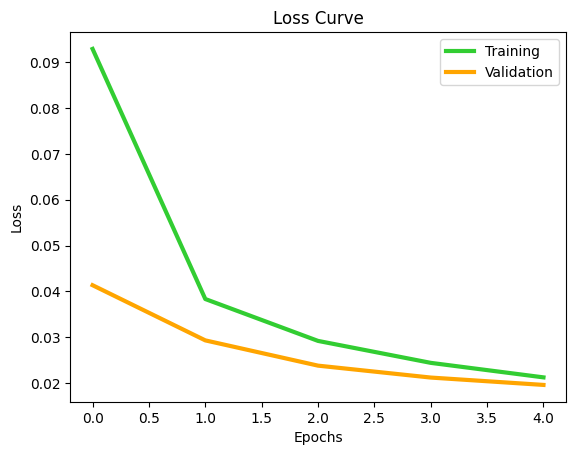

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.plot(history_bert.history['loss'],linewidth=3,color='limegreen')
plt.plot(history_bert.history['val_loss'],linewidth=3,color='orange')  # Plot the chart
plt.legend(["Training", "Validation"], loc ="upper right")

150/150 [==============================] - 17s 66ms/step


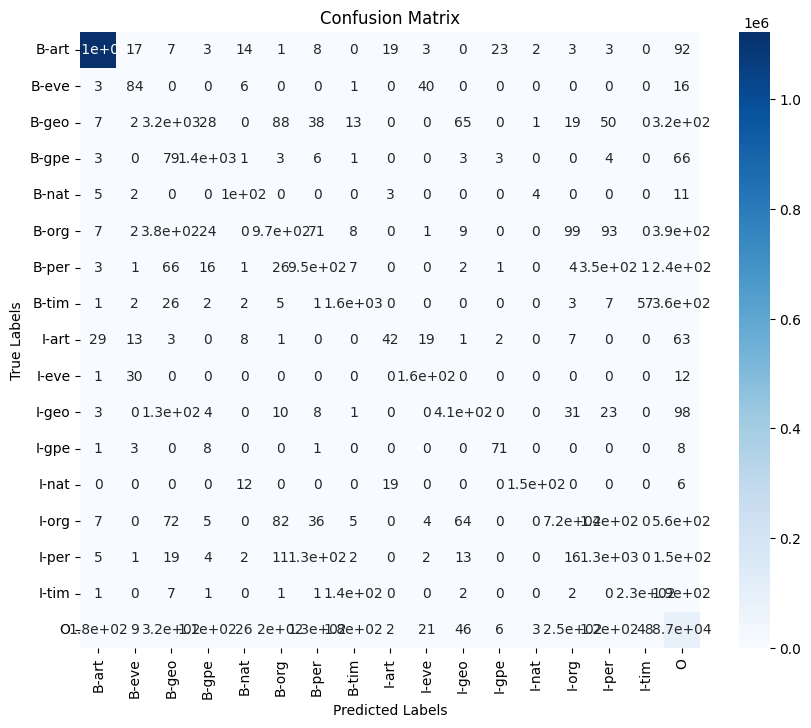

In [ ]:
predictions = model.predict([val_input_ids, val_attention_mask])
predicted_labels = np.argmax(predictions, axis=2)
true_labels_flat = np.concatenate(test_tag)
predicted_labels_flat = np.concatenate(predicted_labels)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_flat, predicted_labels_flat)
#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
import seaborn as sns
label_names = enc_pos.classes_  # Assuming `enc_pos` is the label encoder used in your code

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
y_pred = np.argmax(model.predict([val_input_ids, val_attention_mask]), axis=2)
y_pred_labels = enc_pos.inverse_transform(y_pred.reshape(-1))
y_true_labels = np.array(test_tag).flatten()
encoded_pred_labels = enc_pos.transform(y_pred_labels)
from sklearn.metrics import classification_report
label_names = enc_pos.inverse_transform(np.arange(len(enc_pos.classes_)))

report = classification_report(y_true_labels, encoded_pred_labels, target_names=label_names)
print(report)


150/150 [==============================] - 6s 31ms/step
              precision    recall  f1-score   support

       B-art       1.00      1.00      1.00   1122499
       B-eve       0.51      0.56      0.53       150
       B-geo       0.74      0.83      0.78      3797
       B-gpe       0.88      0.89      0.88      1592
       B-nat       0.59      0.80      0.68       128
       B-org       0.70      0.47      0.56      2055
       B-per       0.69      0.57      0.62      1668
       B-tim       0.81      0.77      0.79      2033
       I-art       0.49      0.22      0.31       188
       I-eve       0.64      0.79      0.71       204
       I-geo       0.66      0.57      0.61       713
       I-gpe       0.67      0.77      0.72        92
       I-nat       0.94      0.80      0.86       183
       I-org       0.62      0.42      0.50      1699
       I-per       0.62      0.79      0.69      1658
       I-tim       0.69      0.40      0.50       585
           O       0.97  

Overall accuracy has not increased but the category wise accuracy has increased in many places. Oversampling and pretrained BERT has increase the score

### BERT Conclusion

In [ ]:
# Sample sentence
sample_sentence = "Mike and Jake wanted to go to Disneyland"

# Tokenize the sample sentence
tokens = tokenizer.encode_plus(np.array(sample_sentence.split()),
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')


input_ids=tokens['input_ids']
attention_mask=tokens['attention_mask']

# Convert tokens to input IDs and attention mask
# input_ids = tokenizer.convert_tokens_to_ids(tokens)
# attention_mask = [1] * len(input_ids)

# Pad the input IDs and attention mask
input_ids = input_ids #+ [0] * (MAX_LEN - len(input_ids))
attention_mask = attention_mask #+ [0] * (MAX_LEN - len(attention_mask))

# Reshape the input IDs and attention mask for prediction
input_ids = np.array(input_ids).reshape(1, -1)
attention_mask = np.array(attention_mask).reshape(1, -1)

# Make predictions
predictions = model.predict([input_ids, attention_mask])
predicted_labels = np.argmax(predictions, axis=2)[0]

# Map the predicted labels to their corresponding tag names
predicted_tags = enc_pos.inverse_transform(predicted_labels)

# Print the tokens and predicted POS tags
for token, tag in zip(sample_sentence.split(), predicted_tags):
    print(f"Token: {token:<10} Predicted POS: {tag}")

1/1 [==============================] - 2s 2s/step
Token: Mike       Predicted POS: B-per
Token: and        Predicted POS: O
Token: Jake       Predicted POS: B-per
Token: wanted     Predicted POS: O
Token: to         Predicted POS: O
Token: go         Predicted POS: O
Token: to         Predicted POS: O
Token: Disneyland Predicted POS: B-org
